# Imports, data loading and such

In [1]:
import warnings
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=Warning)
IPythonConsole.ipython_useSVG=True
np.random.seed(148260)

N_SPLITS = 2
RANDOM_STATE = 148260

In [2]:
def CalculateMorganFingerprint(mol):
    mfpgen = AllChem.GetMorganGenerator(radius=2,fpSize=2048)
    fingerprint = np.array([mfpgen.GetFingerprintAsNumPy(x) for x in mol])
    fingerprint = pd.DataFrame(fingerprint, columns = ['mfp'+str(i) for i in range(fingerprint.shape[1])])
    return fingerprint

def CalculateDescriptors(mol):
    calc = Calculator(descriptors, ignore_3D=False)
    X_mordred = calc.pandas(mol, nproc=1)
    X_mordred = X_mordred.select_dtypes(['number'])
    #normalize
    X_mordred = (X_mordred-X_mordred.min())/(X_mordred.max()-X_mordred.min())
    #drop columns wth low std
    X_mordred = X_mordred.loc[:,X_mordred.std()>0.01]
    return X_mordred

def LoadDatasetCSV(path, threshold=7.0, regression = False):
    df = pd.read_csv(path)
    df['molecule_from_smiles'] = df['smiles'].apply(Chem.MolFromSmiles)
    df['smiles'] = df['smiles'].map(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
    df.drop_duplicates('smiles')
    df = df.dropna()
    if regression:
        df['Target'] = df['pIC50']
    else:
        df['Target'] = df['pIC50'] > threshold
    return df

def split_data(df, approach = 'desc', split = 0.7):
    #TODO: support for different approaches - if applicable
    if approach == 'desc':
        X = CalculateDescriptors(df['molecule_from_smiles'])
    else:
        X = CalculateMorganFingerprint(df['molecule_from_smiles'])
    y = df["Target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-split), random_state=42)
    return X_train, y_train, X_test, y_test

In [3]:
data_classification = LoadDatasetCSV("data/processed/simple_input_data.csv")
data_classification.head()

,smiles,pIC50,molecule_from_smiles,Target
0,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...,9.154901,<rdkit.Chem.rdchem.Mol object at 0x00000265258...,True
1,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...,8.853872,<rdkit.Chem.rdchem.Mol object at 0x00000265258...,True
2,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x00000265258...,True
3,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x00000265258...,True
4,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x00000265258...,True


In [4]:
data_regression = LoadDatasetCSV("data\processed\simple_input_data.csv", regression=True)
data_regression.head()

,smiles,pIC50,molecule_from_smiles,Target
0,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...,9.154901,<rdkit.Chem.rdchem.Mol object at 0x0000026525E...,9.154901
1,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...,8.853872,<rdkit.Chem.rdchem.Mol object at 0x0000026525E...,8.853872
2,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000026525E...,8.698970
3,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000026525E...,8.698970
4,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...,8.698970,<rdkit.Chem.rdchem.Mol object at 0x0000026525E...,8.698970


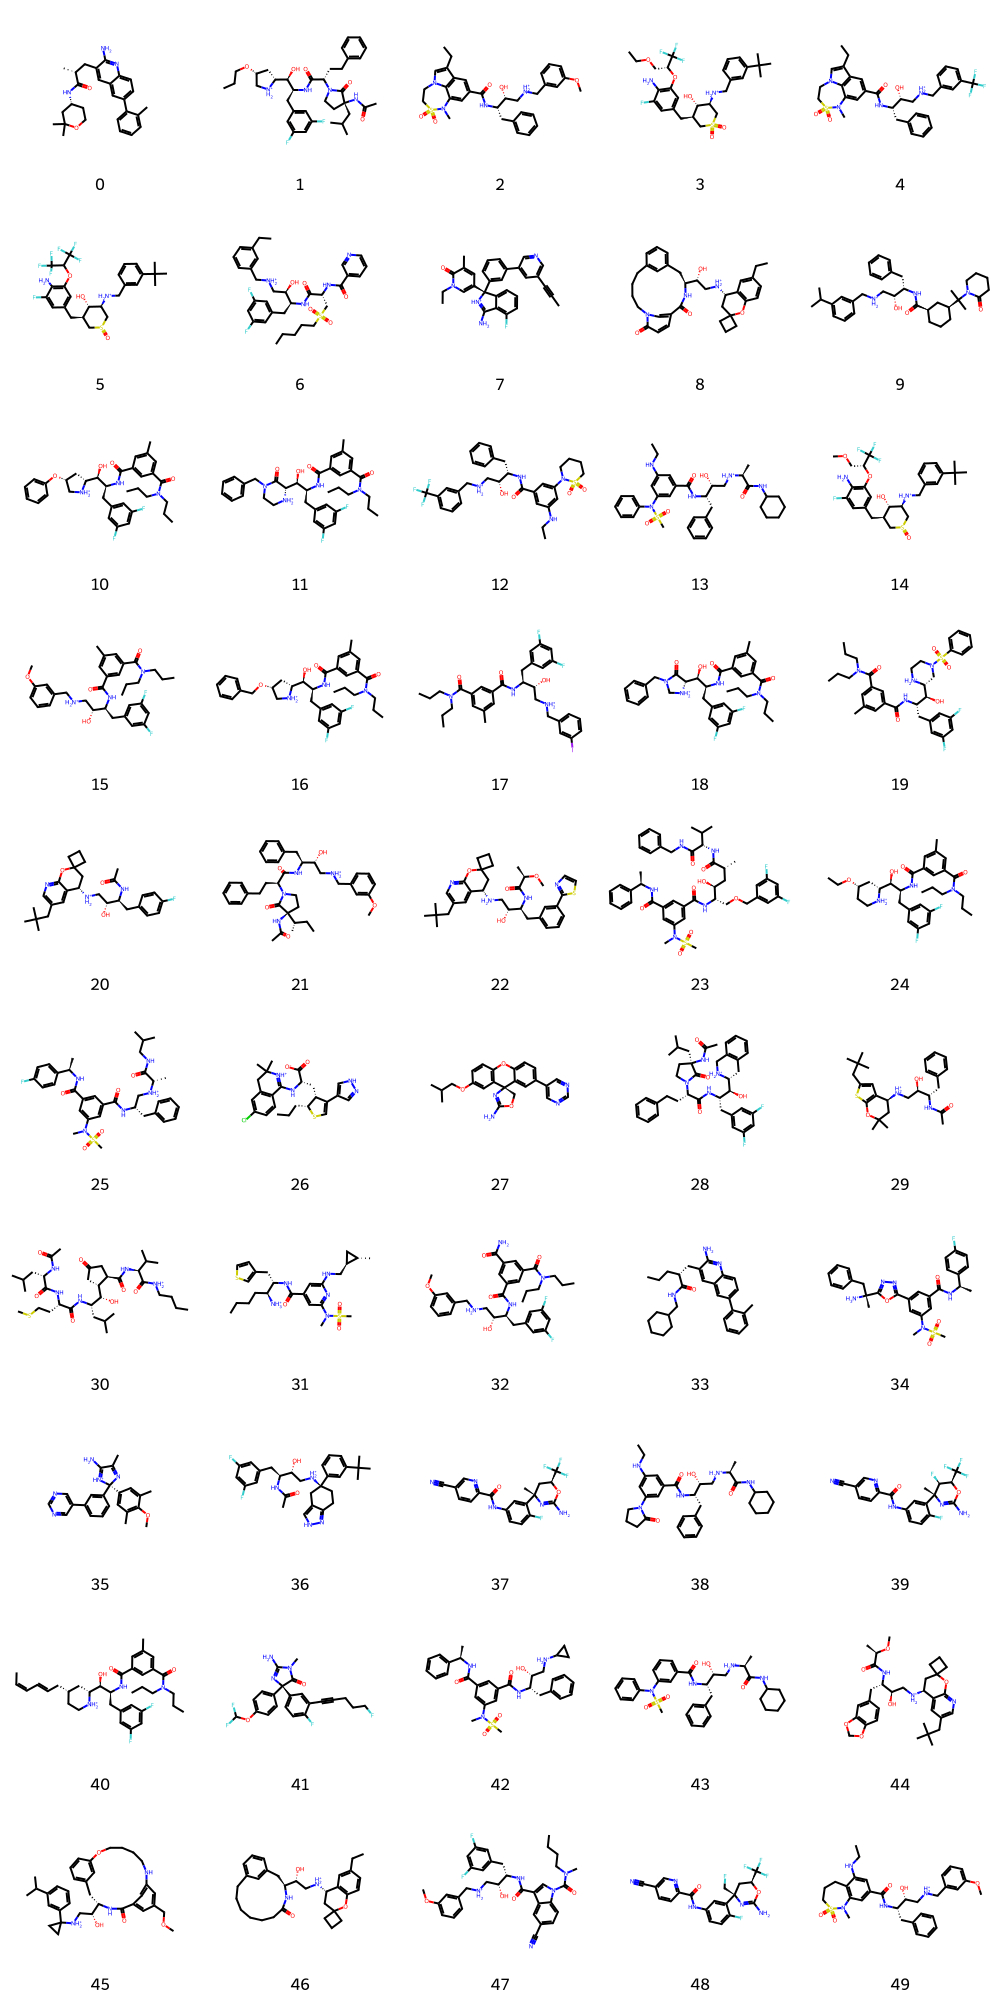

In [5]:
Draw.MolsToGridImage(data_classification['molecule_from_smiles'], molsPerRow=5, legends=[str(i) for i in range(len(data_classification['molecule_from_smiles']))])

In [6]:
df_desc = CalculateDescriptors(data_classification['molecule_from_smiles'])
df_desc['Target'] = data_classification['Target']

  0%|          | 0/1519 [00:00<?, ?it/s]

100%|██████████| 1519/1519 [04:42<00:00,  5.38it/s]


In [7]:
import copy
df_desc_reg = copy.deepcopy(df_desc)
df_desc_reg['Target'] = data_regression['Target']

In [8]:
df_fp = CalculateMorganFingerprint(data_classification['molecule_from_smiles'])
df_fp['Target'] = data_classification['Target']

In [9]:
df_fp_reg = CalculateMorganFingerprint(data_regression['molecule_from_smiles'])
df_fp_reg['Target'] = data_regression['Target']

# Analysis on descriptors

## First look at the data and feature selection

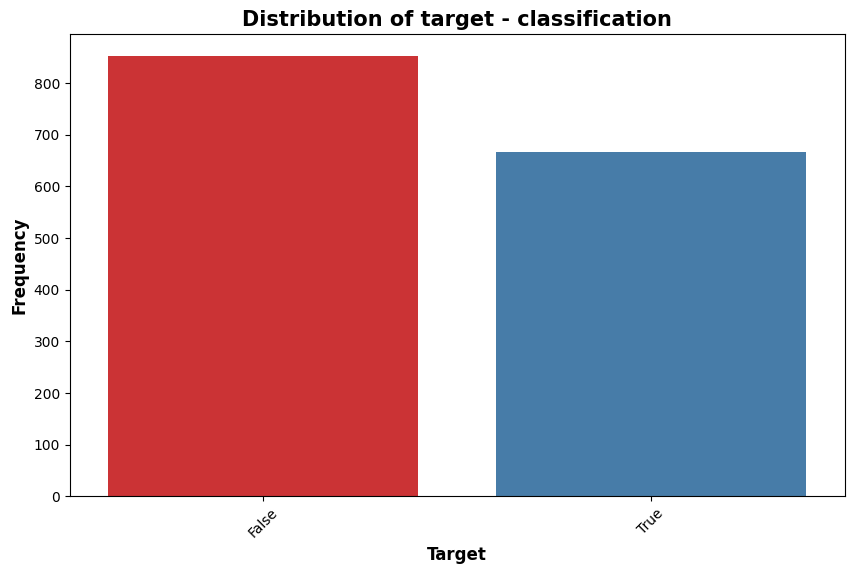

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_desc, x='Target', palette='Set1')
plt.title("Distribution of target - classification",fontsize = 15, fontweight = 'bold', color = 'black')
plt.xlabel("Target",fontsize = 12, fontweight = 'bold', color = 'black')
plt.ylabel("Frequency",fontsize = 12, fontweight = 'bold', color = 'black')
plt.xticks(rotation=45)
plt.show()

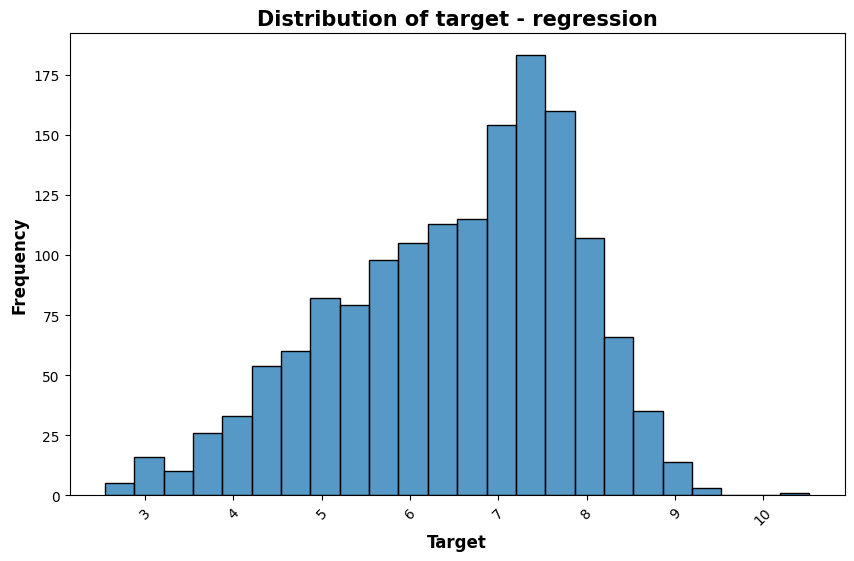

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_desc_reg, x='Target', palette='Set1')
plt.title("Distribution of target - regression",fontsize = 15, fontweight = 'bold', color = 'black')
plt.xlabel("Target",fontsize = 12, fontweight = 'bold', color = 'black')
plt.ylabel("Frequency",fontsize = 12, fontweight = 'bold', color = 'black')
plt.xticks(rotation=45)
plt.show()

In [12]:
df_desc.Target.describe()

count      1519
unique        2
top       False
freq        852
Name: Target, dtype: object

In [13]:
df_desc_reg.Target.describe()

count    1519.000000
mean        6.524056
std         1.345446
min         2.544546
25%         5.585027
50%         6.769551
75%         7.552842
max        10.522879
Name: Target, dtype: float64

In [14]:
df_desc.drop('Target', axis=1).describe()

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
mean,0.008065,0.375082,0.287844,0.620890,0.590036,0.287844,0.556033,0.545073,0.372654,0.324459,...,0.698006,0.361017,0.281988,0.379089,0.056682,0.324669,0.311217,0.327720,0.245292,0.263923
std,0.058605,0.259991,0.097215,0.161689,0.142622,0.097215,0.172527,0.106000,0.111064,0.115105,...,0.093613,0.092125,0.100966,0.171589,0.049631,0.094463,0.094695,0.092535,0.103853,0.100143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.219587,0.495327,0.492958,0.219587,0.439162,0.477895,0.308942,0.242680,...,0.656053,0.312122,0.207188,0.250938,0.025660,0.266187,0.247706,0.268000,0.168083,0.190476
50%,0.000000,0.250000,0.274093,0.623682,0.572392,0.274093,0.550597,0.546340,0.357973,0.324439,...,0.708383,0.360800,0.269100,0.351031,0.043504,0.323741,0.302752,0.322000,0.235896,0.246753
75%,0.000000,0.500000,0.351034,0.776640,0.717404,0.351034,0.682963,0.620677,0.418204,0.388825,...,0.755056,0.411669,0.352204,0.480502,0.077232,0.388489,0.376147,0.387000,0.313080,0.328102
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df_corr = df_desc.drop('Target', axis=1).apply(lambda x: x.corr(df_desc.Target))
golden_features_list = df_corr[abs(df_corr) > 0.4].sort_values(ascending=False)
print("There is {} moderately correlated values with the target:\n{}".format(len(golden_features_list), golden_features_list))

There is 4 moderately correlated values with the target:
ATS3dv    0.426378
IC2       0.411374
ATS2dv    0.401016
GGI6      0.400165
dtype: float64


In [16]:
sns_corr_df = df_desc[list(golden_features_list.index.values)]
sns_corr_df['Target'] = df_desc['Target']

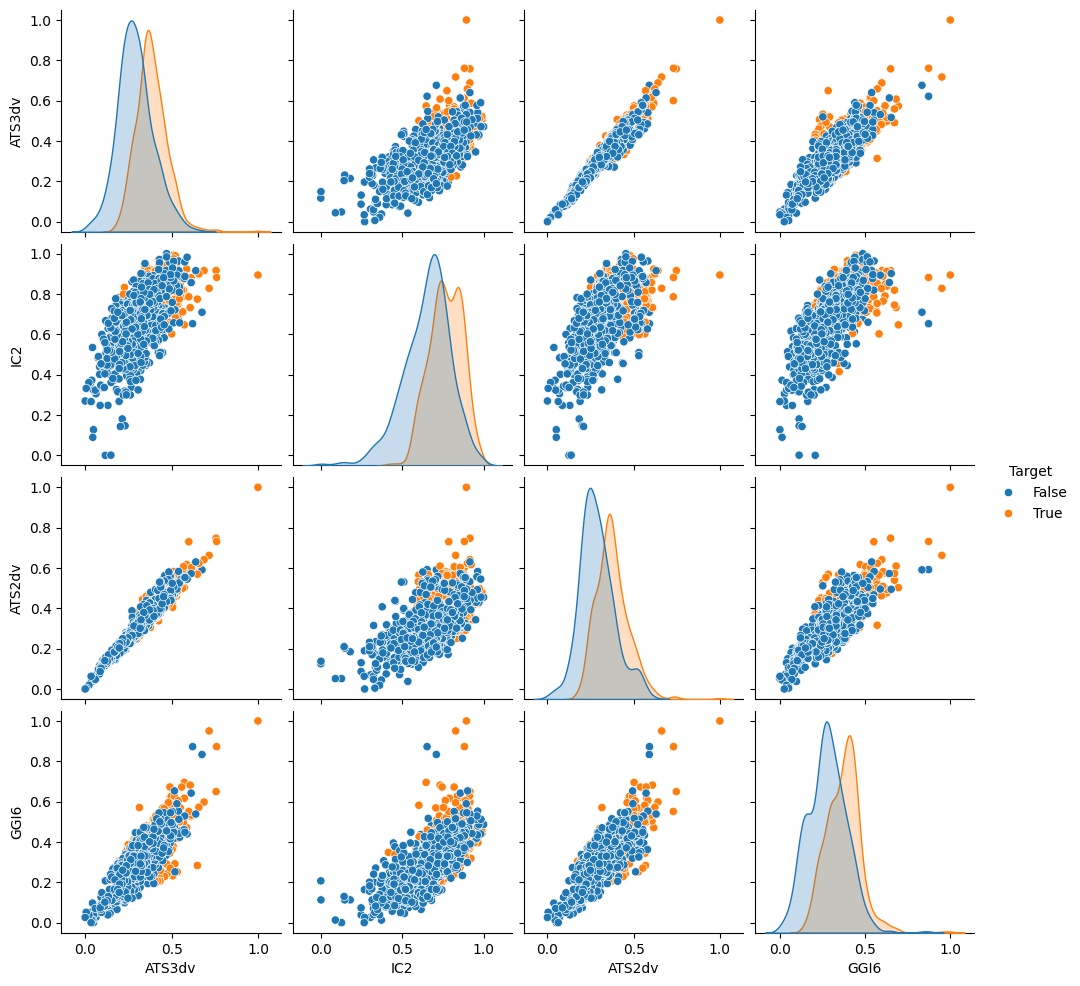

In [17]:
sns.pairplot(sns_corr_df, hue='Target', size=2.5)

In [18]:
df_corr = df_desc_reg.drop('Target', axis=1).apply(lambda x: x.corr(df_desc_reg.Target))
golden_features_list = df_corr[abs(df_corr) > 0.4].sort_values(ascending=False)
print("There is {} moderately correlated values with the target:\n{}".format(len(golden_features_list), golden_features_list))

There is 232 moderately correlated values with the target:
SRW08       0.580521
SRW10       0.574184
MWC05       0.569474
MWC06       0.569340
SRW06       0.565977
              ...   
VE2_Dzse   -0.512965
VE2_Dzm    -0.513019
VE2_DzZ    -0.513067
VE2_Dzv    -0.516316
VE2_Dzp    -0.520019
Length: 232, dtype: float64


Just based on this it seems like the regression approach might fit our problem much better - the question remains about the threshold. For the sake of simplicity lets put it up a bit so that the plot is more comprehensible.

In [19]:
df_corr = df_desc_reg.drop('Target', axis=1).apply(lambda x: x.corr(df_desc_reg.Target))
golden_features_list = df_corr[abs(df_corr) > 0.55].sort_values(ascending=False)
print("There is {} well correlated values with the target:\n{}".format(len(golden_features_list), golden_features_list))

There is 7 well correlated values with the target:
SRW08    0.580521
SRW10    0.574184
MWC05    0.569474
MWC06    0.569340
SRW06    0.565977
MWC04    0.563146
MWC07    0.558949
dtype: float64


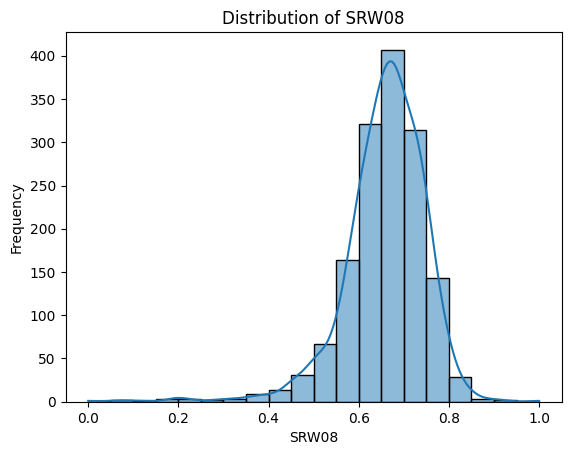

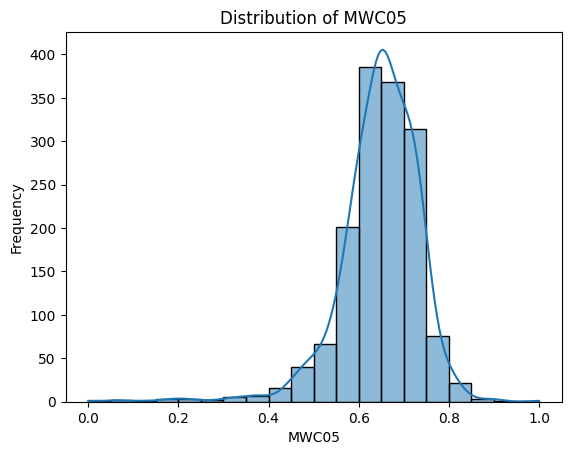

In [20]:
sns.histplot(data=df_desc_reg, x='SRW08', bins=20, kde=True)
plt.title('Distribution of SRW08')
plt.xlabel('SRW08')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data=df_desc_reg, x='MWC05', bins=20, kde=True)
plt.title('Distribution of MWC05')
plt.xlabel('MWC05')
plt.ylabel('Frequency')
plt.show()

In [21]:
sns_corr_df = df_desc_reg[list(golden_features_list.index.values)]
sns_corr_df['Target'] = df_desc_reg['Target']
sns_corr_df['Target_hue'] = df_desc['Target']

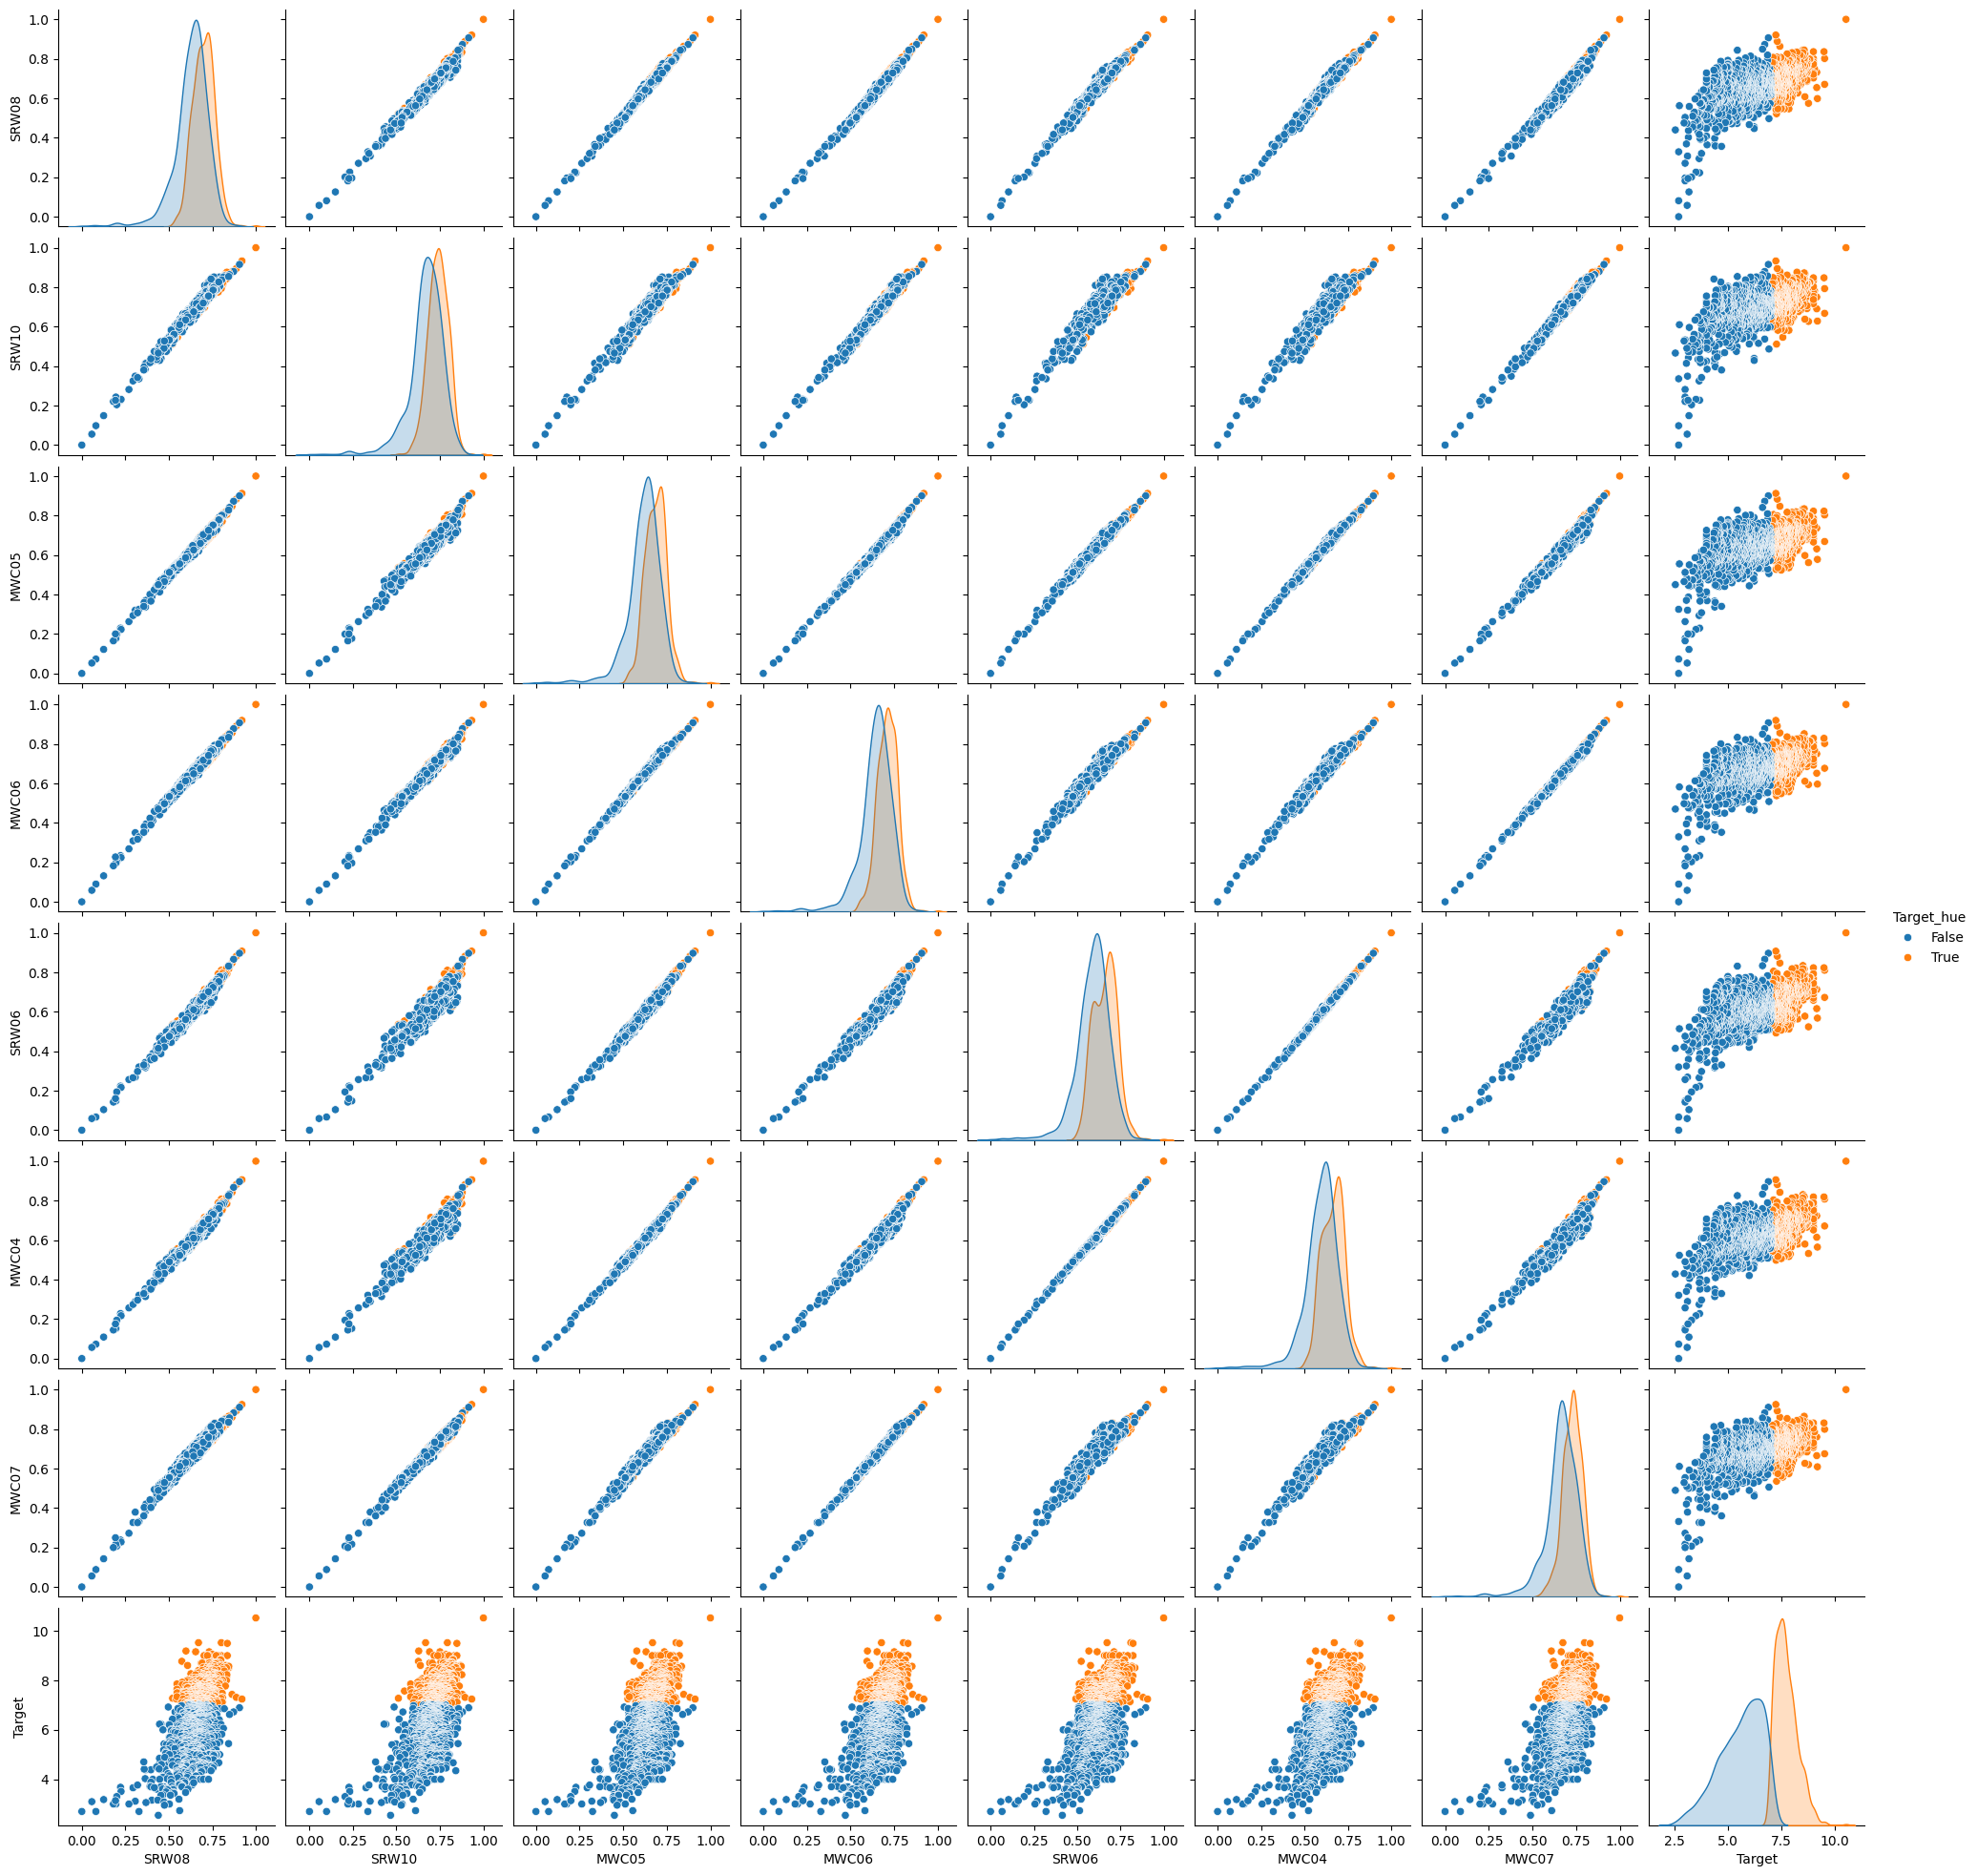

In [22]:
sns.pairplot(sns_corr_df, hue='Target_hue', size=2.5)

The question remains - is there any sense in dropping some features? There are not many that are strongly correlated with our target, so it seems redundant on that front. Now, let's check if some of the features values overlap.

In [23]:
def delete_same_col(df):
    cols = df.select_dtypes([np.number]).columns
    std = df[cols].std()
    cols_to_drop = std[std==0].index
    df = df.drop(cols_to_drop, axis=1)

    return df

desc_dropped = delete_same_col(df_desc.drop('Target', axis=1))

In [24]:
print(f"""
Columns before deletion = 1220
Columns after deletion = {desc_dropped.shape[1]}
""")


Columns before deletion = 1220
Columns after deletion = 1220



In [25]:
def delete_correlated_col(df):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    cols_to_drop = [cols for cols in upper.columns if any(upper[cols] > 0.95)]
    df.drop(cols_to_drop, axis=1, inplace=True)
    return df

desc_dropped = delete_same_col(desc_dropped)

In [26]:
print(f"""
Columns before deletion = 1220
Columns after deletion = {desc_dropped.shape[1]}
""")


Columns before deletion = 1220
Columns after deletion = 1220



Oh, so none of the descriptors are worth deleting. Let's move on to feature projection.

## Feature projection and training

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score

def print_results_classification(model_name, y_true, y_pred):
    print(f"Results for {model_name}:")
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

def print_results_regression(model_name, y_true, y_pred):
    print(f"Results for {model_name}:")
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
        
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2): {r2}")

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_desc.drop('Target', axis=1), df_desc['Target'], test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1215, 1220), (304, 1220), (1215,), (304,))

In [29]:
from sklearn.pipeline import Pipeline

ss = StandardScaler()
pca = PCA(n_components = 0.9, random_state=0)
pca_pipeline = Pipeline([('scaler', ss), ('PCA', pca)])

In [30]:
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

In [31]:
print(f"""
Columns before PCA = 1220
Columns after PCA = {X_train_pca.shape[1]}
""")


Columns before PCA = 1220
Columns after PCA = 38



In [32]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_pca, y_train)
random_forest_predictions = random_forest_model.predict(X_test_pca)

In [33]:
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train_pca, y_train)
logistic_reg_predictions = logistic_reg_model.predict(X_test_pca)

In [34]:
mlp_model = MLPClassifier()
mlp_model.fit(X_train_pca, y_train)
mlp_predictions = mlp_model.predict(X_test_pca)

In [35]:
gradient_boost_model = GradientBoostingClassifier()
gradient_boost_model.fit(X_train_pca, y_train)
gradient_boost_predictions = gradient_boost_model.predict(X_test_pca)

In [36]:
print_results_classification('RandomForestClassifier', y_test.values, random_forest_predictions)
print_results_classification('LogisticRegression', y_test.values, logistic_reg_predictions)
print_results_classification('MLPClassifier', y_test.values, mlp_predictions)
print_results_classification('GradientBoostingClassifier', y_test.values, gradient_boost_predictions)

Results for RandomForestClassifier:
Accuracy: 0.8026315789473685
Precision: 0.8148148148148148
Recall: 0.7586206896551724
F1 Score: 0.7857142857142857
Results for LogisticRegression:
Accuracy: 0.7796052631578947
Precision: 0.7671232876712328
Recall: 0.7724137931034483
F1 Score: 0.7697594501718212
Results for MLPClassifier:
Accuracy: 0.7894736842105263
Precision: 0.7793103448275862
Recall: 0.7793103448275862
F1 Score: 0.7793103448275862
Results for GradientBoostingClassifier:
Accuracy: 0.7861842105263158
Precision: 0.7941176470588235
Recall: 0.7448275862068966
F1 Score: 0.7686832740213524


In [37]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df_desc_reg.drop('Target', axis=1), df_desc_reg['Target'], test_size=0.2, random_state=RANDOM_STATE)
X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((1215, 1220), (304, 1220), (1215,), (304,))

In [38]:
ss = StandardScaler()
pca = PCA(n_components = 0.9, random_state=0)
pca_pipeline = Pipeline([('scaler', ss), ('PCA', pca)])

In [39]:
X_train_pca = pca_pipeline.fit_transform(X_train_reg)
X_test_pca = pca_pipeline.transform(X_test_reg)

In [40]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train_pca, y_train_reg)
random_forest_predictions = random_forest_model.predict(X_test_pca)

In [41]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_pca, y_train_reg)
linear_reg_predictions = linear_reg_model.predict(X_test_pca)

In [42]:
mlp_model = MLPRegressor()
mlp_model.fit(X_train_pca, y_train_reg)
mlp_predictions = mlp_model.predict(X_test_pca)

In [43]:
gradient_boost_model = GradientBoostingRegressor()
gradient_boost_model.fit(X_train_pca, y_train_reg)
gradient_boost_predictions = gradient_boost_model.predict(X_test_pca)

In [44]:
print_results_regression('RandomForestRegressor', y_test_reg, random_forest_predictions)
print_results_regression('LinearRegression', y_test_reg, linear_reg_predictions)
print_results_regression('MLPRegressor', y_test_reg, mlp_predictions)
print_results_regression('GradientBoostingRegressor', y_test_reg, gradient_boost_predictions)

Results for RandomForestRegressor:
Mean Absolute Error: 0.6177996882432096
Mean Squared Error: 0.7092553980501017
R-squared (R2): 0.590894849444537
Results for LinearRegression:
Mean Absolute Error: 0.728074303588839
Mean Squared Error: 0.8913722268664342
R-squared (R2): 0.48584815839866036
Results for MLPRegressor:
Mean Absolute Error: 0.7290120867468047
Mean Squared Error: 1.1093516617685832
R-squared (R2): 0.3601155805729518
Results for GradientBoostingRegressor:
Mean Absolute Error: 0.6674356869027744
Mean Squared Error: 0.7461588221604226
R-squared (R2): 0.569608609088565


# Analysis on fingerprints

Morgan fingerprints, also recognized as circular fingerprints or Extended Connectivity Fingerprints (ECFP), stand as a molecular representation technique extensively employed in the realms of chemoinformatics and computational chemistry. They serve the purpose of encoding vital information pertaining to a molecule's structural attributes.

To elaborate, Morgan fingerprints are crafted by evaluating the existence or non-existence of substructures (circular substructures, denoted as "ECFP" or Extended Connectivity of Functional Groups) within a specified radius surrounding each atom within a molecule. The outcome manifests as a fixed-length binary vector, commonly known as a bitstring, encapsulating information about the presence or absence of particular substructures.

These fingerprints find widespread utility in diverse applications such as similarity searches, compound clustering, and the facilitation of machine learning-based predictive models within the realm of chemoinformatics. Their popularity stems from their ability to articulate molecular structures in a manner conducive to the requirements of machine learning algorithms.

The pivotal parameter influencing Morgan fingerprints is the radius, dictating the extent to which the algorithm considers bonds emanating from each atom during fingerprint generation. Larger radii inherently encapsulate a more comprehensive spectrum of global structural information, albeit at the cost of yielding longer fingerprint vectors.

In essence, Morgan fingerprints offer a systematic means of portraying a molecule's structural attributes, presenting them in a computational format amenable to in-depth analysis and the application of machine learning methodologies, particularly in the realms of chemistry and drug discovery.

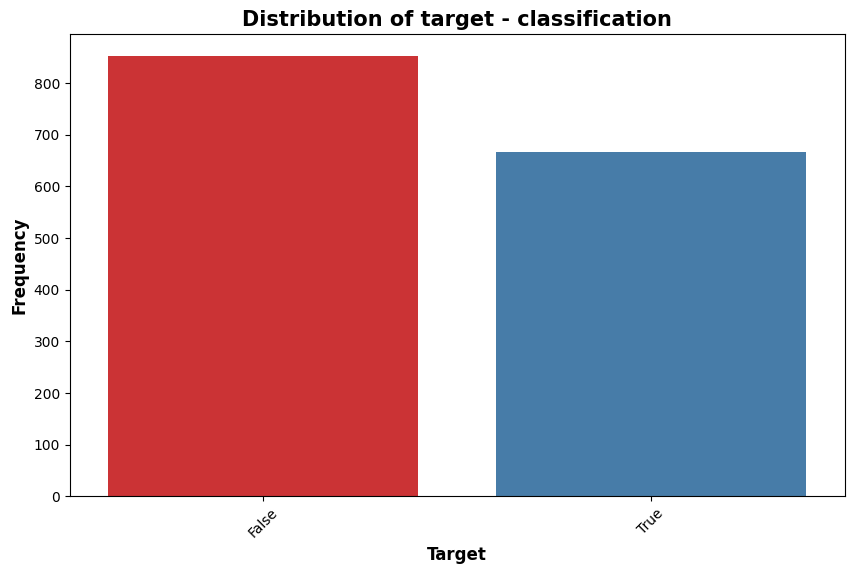

In [45]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_fp, x='Target', palette='Set1')
plt.title("Distribution of target - classification",fontsize = 15, fontweight = 'bold', color = 'black')
plt.xlabel("Target",fontsize = 12, fontweight = 'bold', color = 'black')
plt.ylabel("Frequency",fontsize = 12, fontweight = 'bold', color = 'black')
plt.xticks(rotation=45)
plt.show()

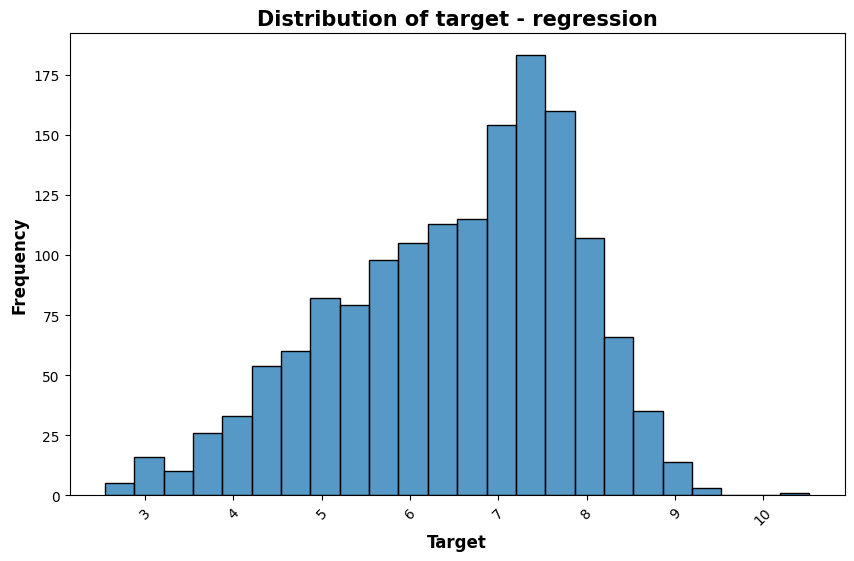

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_fp_reg, x='Target', palette='Set1')
plt.title("Distribution of target - regression",fontsize = 15, fontweight = 'bold', color = 'black')
plt.xlabel("Target",fontsize = 12, fontweight = 'bold', color = 'black')
plt.ylabel("Frequency",fontsize = 12, fontweight = 'bold', color = 'black')
plt.xticks(rotation=45)
plt.show()

In [47]:
df_fp.drop('Target', axis=1).head()

,mfp0,mfp1,mfp2,mfp3,mfp4,mfp5,mfp6,mfp7,mfp8,mfp9,...,mfp2038,mfp2039,mfp2040,mfp2041,mfp2042,mfp2043,mfp2044,mfp2045,mfp2046,mfp2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_corr = df_fp.drop('Target', axis=1).apply(lambda x: x.corr(df_fp.Target))
golden_features_list = df_corr[abs(df_corr) > 0.24].sort_values(ascending=False)
print("There is {} weakly correlated values with the target:\n{}".format(len(golden_features_list), golden_features_list))

There is 6 weakly correlated values with the target:
mfp136     0.257701
mfp1453    0.251396
mfp1928    0.246465
mfp1643    0.244427
mfp126     0.241538
mfp1840    0.240563
dtype: float64


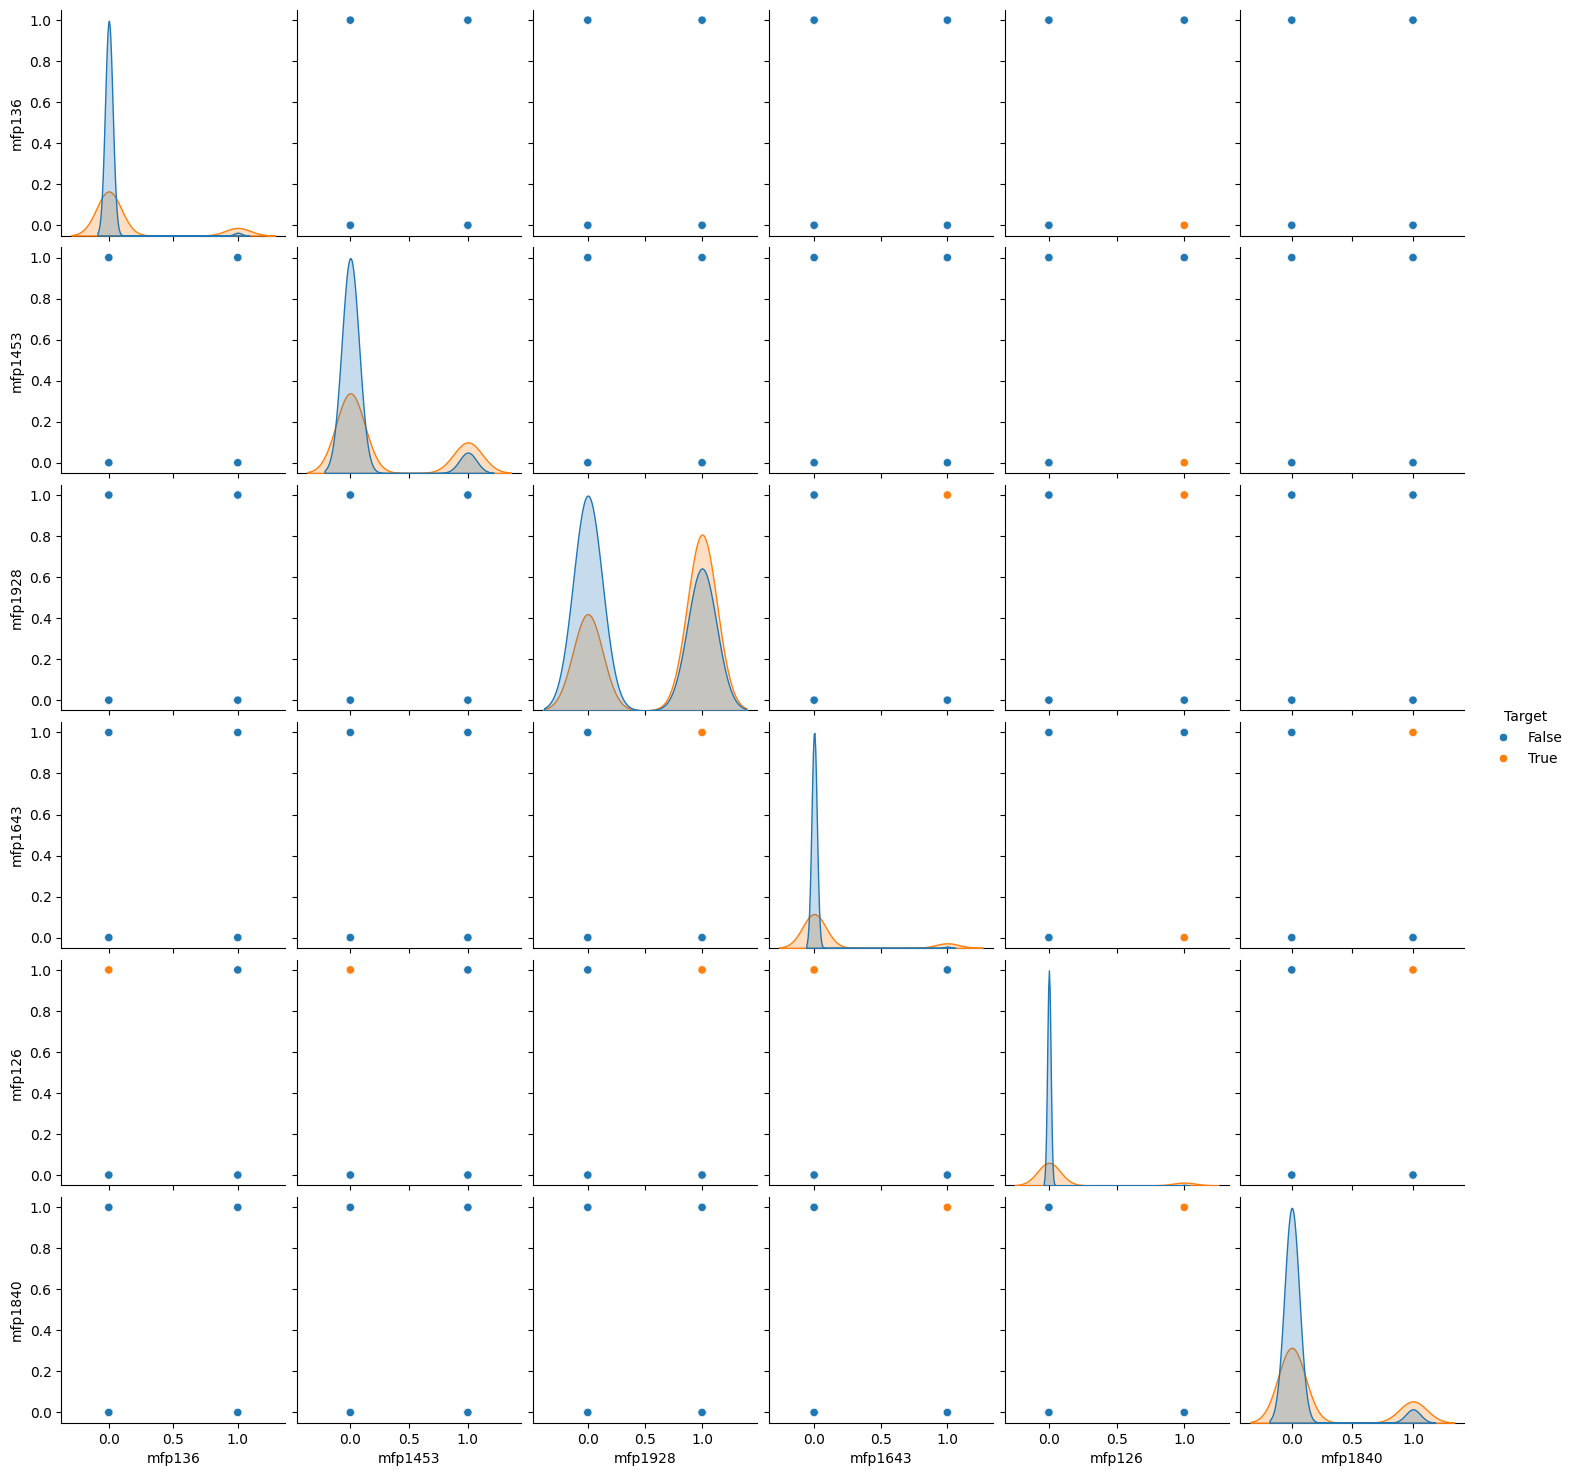

In [49]:
sns_corr_df = df_fp[list(golden_features_list.index.values)]
sns_corr_df['Target'] = df_fp['Target']
sns.pairplot(sns_corr_df, hue='Target', size=2.5)

Nonsensical plot

In [50]:
df_corr = df_fp_reg.drop('Target', axis=1).apply(lambda x: x.corr(df_fp_reg.Target))
golden_features_list = df_corr[abs(df_corr) > 0.3].sort_values(ascending=False)
print("There is {} moderately correlated values with the target:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 moderately correlated values with the target:
mfp1928    0.304864
mfp506    -0.301077
mfp1394   -0.302423
mfp1855   -0.303599
mfp964    -0.364521
dtype: float64


Much better than classification, once again

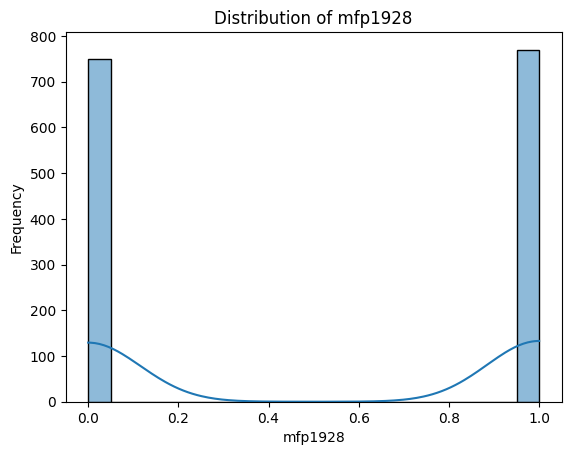

In [51]:
sns.histplot(data=df_fp_reg, x='mfp1928', bins=20, kde=True)
plt.title('Distribution of mfp1928')
plt.xlabel('mfp1928')
plt.ylabel('Frequency')
plt.show()

In [52]:
def delete_same_col(df):
    cols = df.select_dtypes([np.number]).columns
    std = df[cols].std()
    cols_to_drop = std[std==0].index
    df = df.drop(cols_to_drop, axis=1)

    return df

desc_dropped = delete_same_col(df_fp.drop('Target', axis=1))

In [53]:
print(f"""
Columns before deletion = 2048
Columns after deletion = {desc_dropped.shape[1]}
""")


Columns before deletion = 2048
Columns after deletion = 1865



In [54]:
def delete_correlated_col(df):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    cols_to_drop = [cols for cols in upper.columns if any(upper[cols] > 0.95)]
    df.drop(cols_to_drop, axis=1, inplace=True)
    return df

desc_dropped = delete_same_col(desc_dropped)

In [55]:
print(f"""
Columns before deletion = 1865
Columns after deletion = {desc_dropped.shape[1]}
""")


Columns before deletion = 1865
Columns after deletion = 1865



So there are fingerprint columns that are completely useless - it's good to filter them out first, so that learning goes by faster.

Let's carry on to feature projection.

In [56]:
df_fp_after_feature_selection = delete_same_col(df_fp)

In [57]:
df_fp_after_feature_selection

,mfp0,mfp1,mfp2,mfp3,mfp4,mfp5,mfp6,mfp7,mfp8,mfp9,...,mfp2038,mfp2039,mfp2040,mfp2041,mfp2042,mfp2044,mfp2045,mfp2046,mfp2047,Target
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1515,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False


In [58]:
df_fp_reg_after_feature_selection = delete_same_col(df_fp_reg)

## Feature projection and training

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score

def print_results_classification(model_name, y_true, y_pred):
    print(f"Results for {model_name}:")
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

def print_results_regression(model_name, y_true, y_pred):
    print(f"Results for {model_name}:")
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
        
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2): {r2}")

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_fp_after_feature_selection.drop('Target', axis=1), df_fp_after_feature_selection['Target'], test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1215, 1865), (304, 1865), (1215,), (304,))

In [61]:
from sklearn.pipeline import Pipeline

ss = StandardScaler()
pca = PCA(n_components = 0.9, random_state=0)
pca_pipeline = Pipeline([('scaler', ss), ('PCA', pca)])

In [62]:
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

In [63]:
print(f"""
Columns before PCA = 1865
Columns after PCA = {X_train_pca.shape[1]}
""")


Columns before PCA = 1865
Columns after PCA = 434



In [64]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_pca, y_train)
random_forest_predictions = random_forest_model.predict(X_test_pca)

In [65]:
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train_pca, y_train)
logistic_reg_predictions = logistic_reg_model.predict(X_test_pca)

In [66]:
mlp_model = MLPClassifier()
mlp_model.fit(X_train_pca, y_train)
mlp_predictions = mlp_model.predict(X_test_pca)

In [67]:
gradient_boost_model = GradientBoostingClassifier()
gradient_boost_model.fit(X_train_pca, y_train)
gradient_boost_predictions = gradient_boost_model.predict(X_test_pca)

In [68]:
print_results_classification('RandomForestClassifier', y_test.values, random_forest_predictions)
print_results_classification('LogisticRegression', y_test.values, logistic_reg_predictions)
print_results_classification('MLPClassifier', y_test.values, mlp_predictions)
print_results_classification('GradientBoostingClassifier', y_test.values, gradient_boost_predictions)

Results for RandomForestClassifier:
Accuracy: 0.7664473684210527
Precision: 0.8083333333333333
Recall: 0.6689655172413793
F1 Score: 0.7320754716981132
Results for LogisticRegression:
Accuracy: 0.75
Precision: 0.7633587786259542
Recall: 0.6896551724137931
F1 Score: 0.7246376811594204
Results for MLPClassifier:
Accuracy: 0.805921052631579
Precision: 0.8028169014084507
Recall: 0.7862068965517242
F1 Score: 0.794425087108014
Results for GradientBoostingClassifier:
Accuracy: 0.7697368421052632
Precision: 0.7906976744186046
Recall: 0.7034482758620689
F1 Score: 0.7445255474452555


In [69]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df_fp_reg_after_feature_selection.drop('Target', axis=1), df_fp_reg_after_feature_selection['Target'], test_size=0.2, random_state=RANDOM_STATE)
X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((1215, 1865), (304, 1865), (1215,), (304,))

In [70]:
ss = StandardScaler()
pca = PCA(n_components = 0.9, random_state=0)
pca_pipeline = Pipeline([('scaler', ss), ('PCA', pca)])

In [71]:
X_train_pca = pca_pipeline.fit_transform(X_train_reg)
X_test_pca = pca_pipeline.transform(X_test_reg)

In [72]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train_pca, y_train_reg)
random_forest_predictions = random_forest_model.predict(X_test_pca)

In [73]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_pca, y_train_reg)
linear_reg_predictions = linear_reg_model.predict(X_test_pca)

In [74]:
mlp_model = MLPRegressor()
mlp_model.fit(X_train_pca, y_train_reg)
mlp_predictions = mlp_model.predict(X_test_pca)

In [75]:
gradient_boost_model = GradientBoostingRegressor()
gradient_boost_model.fit(X_train_pca, y_train_reg)
gradient_boost_predictions = gradient_boost_model.predict(X_test_pca)

In [76]:
print_results_regression('RandomForestRegressor', y_test_reg, random_forest_predictions)
print_results_regression('LinearRegression', y_test_reg, linear_reg_predictions)
print_results_regression('MLPRegressor', y_test_reg, mlp_predictions)
print_results_regression('GradientBoostingRegressor', y_test_reg, gradient_boost_predictions)

Results for RandomForestRegressor:
Mean Absolute Error: 0.7004631300844415
Mean Squared Error: 0.8692708553601962
R-squared (R2): 0.49859643630024497
Results for LinearRegression:
Mean Absolute Error: 0.658667547993555
Mean Squared Error: 0.7463946517363877
R-squared (R2): 0.5694725803823389
Results for MLPRegressor:
Mean Absolute Error: 1.0871594047270272
Mean Squared Error: 2.0405091001483
R-squared (R2): -0.17698474332513126
Results for GradientBoostingRegressor:
Mean Absolute Error: 0.7218340861704869
Mean Squared Error: 0.8862086208024886
R-squared (R2): 0.48882657469553625
